In [1]:
#%load_ext autoreload
#%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

import pandas as pd
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import multiprocessing

In [2]:
#from torch.utils.data.sampler import RandomSampler
#RandomSampler_num_samples = RandomSampler.num_samples
#@property
#def RandomSampler_num_samples_x10(self): return  self.RandomSampler_num_samples*10
#RandomSampler.num_samples= RandomSampler_num_samples_x10

In [3]:
from torch.nn import Parameter

def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict,
                          missing_keys, unexpected_keys, error_msgs):
    r"""Copies parameters and buffers from :attr:`state_dict` into only
    this module, but not its descendants. This is called on every submodule
    in :meth:`~torch.nn.Module.load_state_dict`. Metadata saved for this
    module in input :attr:`state_dict` is provided as :attr:`local_metadata`.
    For state dicts without metadata, :attr:`local_metadata` is empty.
    Subclasses can achieve class-specific backward compatible loading using
    the version number at `local_metadata.get("version", None)`.

    .. note::
        :attr:`state_dict` is not the same object as the input
        :attr:`state_dict` to :meth:`~torch.nn.Module.load_state_dict`. So
        it can be modified.

    Arguments:
        state_dict (dict): a dict containing parameters and
            persistent buffers.
        prefix (str): the prefix for parameters and buffers used in this
            module
        local_metadata (dict): a dict containing the metadata for this module.
            See
        strict (bool): whether to strictly enforce that the keys in
            :attr:`state_dict` with :attr:`prefix` match the names of
            parameters and buffers in this module
        missing_keys (list of str): if ``strict=True``, add missing keys to
            this list
        unexpected_keys (list of str): if ``strict=True``, add unexpected
            keys to this list
        error_msgs (list of str): error messages should be added to this
            list, and will be reported together in
            :meth:`~torch.nn.Module.load_state_dict`
    """
    for hook in self._load_state_dict_pre_hooks.values():
        hook(state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs)

    local_name_params = itertools.chain(self._parameters.items(),
                                        self._buffers.items())
    local_state = {k: v.data for k, v in local_name_params if v is not None}

    for name, param in local_state.items():
        key = prefix + name
        if key in state_dict:
            input_param = state_dict[key]

            # Backward compatibility: loading 1-dim tensor from 0.3.* to version 0.4+
            if len(param.shape) == 0 and len(input_param.shape) == 1:
                input_param = input_param[0]

            if input_param.shape != param.shape:
                # local shape should match the one in checkpoint
                error_msgs.append(
                    'size mismatch for {}: copying a param with shape {} from checkpoint, '
                    'the shape in current model is {}.'.format(
                        key, input_param.shape, param.shape))
                #if not strict:
                #    continue

            if isinstance(input_param, Parameter):
                # backwards compatibility for serialized parameters
                input_param = input_param.data

            try:
                param.copy_(input_param)
            except Exception:
                error_msgs.append(
                    'While copying the parameter named "{}", '
                    'whose dimensions in the model are {} and '
                    'whose dimensions in the checkpoint are {}.'.format(
                        key, param.size(), input_param.size()))
                # PG load partially

                if len(input_param.size()) == 3:
                    error_msgs.append(
                        'Partially copying the parameter named "{}", '
                        'whose dimensions in the model are {} and '
                        'whose dimensions in the checkpoint are {}. - trying {}'
                        .format(
                            key, param.size(), input_param.size(),
                            param[:input_param.size()[0], :input_param.size(
                            )[1], :input_param.size()[2]].shape))
                else:
                    error_msgs.append(
                        'Partially copying the parameter named "{}", '
                        'whose dimensions in the model are {} and '
                        'whose dimensions in the checkpoint are {}. - trying {}'
                        .format(key, param.size(), input_param.size(),
                                param[:input_param.size()[0]].shape))

                try:
                    new_input_param = torch.empty_like(param)
                    new_input_param = torch.nn.init.normal_(new_input_param,
                                                            mean=input_param.mean(),
                                                            std=input_param.std())

                    if len(input_param.size()) == 3:
                        new_input_param[:input_param.size()[0], :input_param.
                                        size()[1], :input_param.size(
                                        )[2]] = input_param
                    else:
                        new_input_param[:input_param.size()[0]] = input_param
                    param.copy_(new_input_param)
                except Exception as e:
                    assert e
                    error_msgs.append(
                        'Failed to load weights partially {}'.format(e))
        elif strict:
            missing_keys.append(key)

    if strict:
        for key in state_dict.keys():
            if key.startswith(prefix):
                input_name = key[len(prefix):]
                input_name = input_name.split(
                    '.', 1)[0]  # get the name of param/buffer/child
                if input_name not in self._modules and input_name not in local_state:
                    unexpected_keys.append(key)

def load_state_dict(self, state_dict, strict=True):
    r"""Copies parameters and buffers from :attr:`state_dict` into
    this module and its descendants. If :attr:`strict` is ``True``, then
    the keys of :attr:`state_dict` must exactly match the keys returned
    by this module's :meth:`~torch.nn.Module.state_dict` function.

    Arguments:
        state_dict (dict): a dict containing parameters and
            persistent buffers.
        strict (bool, optional): whether to strictly enforce that the keys
            in :attr:`state_dict` match the keys returned by this module's
            :meth:`~torch.nn.Module.state_dict` function. Default: ``True``

    Returns:
        ``NamedTuple`` with ``missing_keys`` and ``unexpected_keys`` fields:
            * **missing_keys** is a list of str containing the missing keys
            * **unexpected_keys** is a list of str containing the unexpected keys
    """
    missing_keys = []
    unexpected_keys = []
    error_msgs = []

    # copy state_dict so _load_from_state_dict can modify it
    metadata = getattr(state_dict, '_metadata', None)
    state_dict = state_dict.copy()
    if metadata is not None:
        state_dict._metadata = metadata

    def load(module, prefix=''):
        local_metadata = {} if metadata is None else metadata.get(
            prefix[:-1], {})
        module._load_from_state_dict(state_dict, prefix, local_metadata, True,
                                     missing_keys, unexpected_keys, error_msgs)
        for name, child in module._modules.items():
            if child is not None:
                load(child, prefix + name + '.')
                
    load(self)

    if strict:
        if len(unexpected_keys) > 0:
            error_msgs.insert(
                0, 'Unexpected key(s) in state_dict: {}. '.format(', '.join(
                    '"{}"'.format(k) for k in unexpected_keys)))
        if len(missing_keys) > 0:
            error_msgs.insert(
                0, 'Missing key(s) in state_dict: {}. '.format(', '.join(
                    '"{}"'.format(k) for k in missing_keys)))

    if strict and len(error_msgs) > 0:
        raise RuntimeError(
            'Error(s) in loading state_dict for {}:\n\t{}'.format(
                self.__class__.__name__, "\n\t".join(error_msgs)))
    return None

In [4]:
nn.Module._load_from_state_dict = _load_from_state_dict
nn.Module.load_state_dict = load_state_dict

In [5]:
from fastai import *
from fastai.basic_train import *
from fastai.basic_data import *
from fastai.data_block import *
from fastai.torch_core import *
from fastai.train import *
from fastai.callback import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.layers import *

In [6]:
ext = '_ext' # or ''
multi = '_molecule'
train_fname = Path('train.npz')
type_index=types = ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'] 
atoms = 'CFHNO'
xyz = ['x', 'y', 'z']
max_atoms = 29 #int(s.atom_index.max() + 1)

fname_ext = lambda fname,ext,multi: f'{str(fname)[:-4]}{ext}{multi}{str(fname)[-4:]}'
s  = pd.read_csv('structures.csv')

In [7]:
def process_group(process_args,i):
    m_group,has_y,x0_xyz,x0_type,x0_ext,x0_atom,x0_id,m0,y0_scalar = process_args
    x0_atom[:] = -1
    x0_type[:] = -1
    x0_id[:] = -1
    y0_scalar[:] = np.nan
    (m_name, m_index) ,m_group = m_group
    ss = s[s.molecule_name==m_name]
    n_atoms = len(ss)
    ii = 0
    x0_xyz[ii] = 0.
    x0_type[ii] = -1
    x0_ext[ii] =  True
    x0_xyz[ii,:,:n_atoms] = ss[xyz].values.T  # xyz 
    x0_type[ii,0,m_group['atom_index_1'], m_group['atom_index_0']] = m_group['type_idx'].T
    x0_ext[ii,0, m_group['atom_index_0']] = m_group['ext'].T
    x0_atom[ii,:,:n_atoms] = ss['atom_idx'].T
    x0_id[ii,0,m_group['atom_index_1'], m_group['atom_index_0']] = m_group['id'].T
    m0[ii] = m_index
    res = [x0_xyz,x0_type,x0_ext,x0_atom,x0_id,m0]
    if has_y:
        y0_scalar[0,0,m_group['atom_index_1'], m_group['atom_index_0']] =  m_group['scalar_coupling_constant']
        res.append(y0_scalar)
    return i,res

In [8]:
def preprocess(fname, type_index=None, ext=''):
    t  = pd.read_csv(fname_ext(fname,ext,''))
    has_y = 'scalar_coupling_constant' in t.columns
    t['molecule_index'] = pd.factorize(t['molecule_name'])[0] + t['id'].min()
    # make sure we use the same indexes in train/test (test needs to provide type_index)
    if type_index is not None:
        t['type_idx'] = t['type'].apply(lambda x: type_index.index(x) ) # pd.factorize(pd.concat([pd.Series(type_index),t['type']]))[0][len(type_index):]
    else:
        t['type_idx'] = pd.factorize(t['type'])[0]

    s['atom_idx'] = s['atom'].apply(lambda x: atoms.index(x) )

    max_items = t['molecule_name'].nunique()
    x_xyz   = np.zeros((max_items,len(xyz),  max_atoms), dtype=np.float32)
    x_type  = np.empty((max_items,1,         max_atoms,max_atoms), dtype=np.int8)
    x_ext   = np.zeros((max_items,1,         max_atoms), dtype=np.bool_)
    x_atom  = np.empty((max_items,1,         max_atoms), dtype=np.int8)
    x_ids   = np.zeros((max_items,           max_atoms,max_atoms), dtype=np.int32)
    x_atom[:] = -1
    x_type[:] = -1
    x_ids[:] = -1
    m = np.zeros((max_items,), dtype=np.int32)
    if has_y:
        y_scalar   = np.empty((max_items,1 ,max_atoms,max_atoms), dtype=np.float32)
        y_scalar[:] = np.nan
        
    x0_xyz   = np.zeros((1,len(xyz),  max_atoms), dtype=np.float32)        
    x0_type  = np.empty((1,1,         max_atoms,max_atoms), dtype=np.int8)
    x0_ext   = np.zeros((1,1,         max_atoms), dtype=np.bool_)
    x0_atom  = np.empty((1,1,         max_atoms), dtype=np.int8)
    x0_id    = np.zeros((1,1,         max_atoms,max_atoms), dtype=np.int32)
    y0_scalar   = np.empty((1,1 ,max_atoms,max_atoms), dtype=np.float32)
    m0 = np.zeros((1,), dtype=np.int32)
    
    process_args = [(m_group,has_y,x0_xyz,x0_type,x0_ext,x0_atom,x0_id,m0,y0_scalar) 
                    for m_group in t.groupby(['molecule_name', 'molecule_index'])]
    res = parallel(process_group,process_args,max_workers=multiprocessing.cpu_count())
    for i,r in progress_bar(res):
        x_xyz[i],x_type[i],x_ext[i],x_atom[i],x_ids[i],m[i] = r[:6]
        if has_y: y_scalar[i]=r[6]
        
    res = [x_xyz,x_type,x_ext,x_atom,x_ids,m]
    if has_y: res.append(y_scalar)
    return res

Define where you want to use original training set '' or extended ''

Load preprocessed or preprocess and save for later

In [9]:
train_fname = Path('train.npz')
types = ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'] 
atoms = 'CFHNO'

try:
    npzfile = np.load(fname_ext(train_fname,ext,multi))
    x_xyz   = npzfile['x_xyz']
    x_type  = npzfile['x_type']
    x_ext   = npzfile['x_ext']
    x_atom  = npzfile['x_atom']

    y_scalar    = npzfile['y_scalar']
    m = npzfile['m']
    max_items, max_atoms = x_xyz.shape[0], x_xyz.shape[-1]
except:
    x_xyz,x_type,x_ext,x_atom,x_ids,m,y_scalar=preprocess(train_fname.with_suffix('.csv'),type_index=types,ext=ext)
    np.savez(fname_ext(train_fname,ext,multi), 
             x_xyz=x_xyz,
             x_type=x_type,
             x_ext=x_ext,
             x_atom=x_atom,
             x_ids=x_ids,
             y_scalar=y_scalar,
             m=m)
n_types = int(x_type[~np.isnan(x_type)].max() + 1)

In [10]:
[v.shape for v in [x_xyz,x_type,x_ext,x_atom,
                   y_scalar, m]]

[(85003, 3, 29),
 (85003, 1, 29, 29),
 (85003, 1, 29),
 (85003, 1, 29),
 (85003, 1, 29, 29),
 (85003,)]

In [11]:
x_xyz_mean, x_xyz_std = Tensor(x_xyz.mean(axis=(0,2),keepdims=True)), Tensor(x_xyz.std(axis=(0,2),keepdims=True))

In [12]:
x_xyz_std.shape

torch.Size([1, 3, 1])

Fastai classes (this should should be done into its own `application` but who has time?

In [13]:
class MoleculeItem(ItemBase):
    def __init__(self,i,xyz,type,ext,atom):#,qm9_mulliken,coulomb): 
        self.i,self.xyz,self.type,self.ext, self.atom = \
            i,xyz,type,ext,atom
        self.data = [Tensor(xyz), LongTensor((type)), 
                     Tensor(ext), LongTensor((atom))]
    def __str__(self):
        # TODO: count n_atoms correctly. 
        n_atoms = np.count_nonzero(np.sum(np.absolute(self.xyz), axis=0))+1
        n_couplings = np.sum((self.type!=-1))
        return f'{self.i} {n_atoms} atoms {n_couplings} couplings'
    
    def apply_tfms(self, tfms:Collection, **kwargs):
        x = self.clone()
        for t in tfms:
            if t: x.data = t(x.data)
        return x
    
    def clone(self):
        return self.__class__(self.i,self.xyz,self.type,self.ext,self.atom)#,self.qm9_mulliken,self.coulomb)
    
class ScalarCouplingItem(ItemBase):
    def __init__(self,scalar,**kwargs): 
        self.scalar = scalar#,magnetic,mulliken,dipole,potential
        self.data = Tensor(scalar) #, Tensor(magnetic), Tensor(dipole), Tensor(potential))
    def __str__(self):
        #res, spacer, n_couplings = '', '', 0
        n_couplings = (~torch.isnan(self.data)).sum()
        return f'{n_couplings}'
    def apply_tfms(self, tfms:Collection, **kwargs):
        y = self.clone()
        for t in tfms:
            if 'label_smoothing' == t.__name__:
                if t: y.data = t(y.data)
        return y
    def clone(self): return self.__class__(self.scalar)#,self.magnetic,self.mulliken,self.dipole,self.potential)
    def __hash__(self): return hash(str(self))

In [14]:
class LMAEMaskedLoss(Module):
    def __init__(self,types_w = [1]*n_types, return_all=False, proxy_log=torch.log, exclude_ext=False):
        self.types_w = types_w
        self.return_all = return_all
        self.proxy_log = proxy_log
        self.exclude_ext = exclude_ext
        self.loss = torch.nn.L1Loss()
    
    def forward(self, input_outputs, t_scalar):#, t_magnetic, t_dipole, t_potential):    
        t_mask, type, ext, p_scalar = input_outputs
        loss = 0.
        n = 0
        j_loss = [0] * n_types
        p_scalar = p_scalar.squeeze(-1)
        #print(t_scalar.shape, type.shape)
        t_scalar = t_scalar.view(t_scalar.shape[0],-1)[t_mask] #t_scalar[~torch.isnan(t_scalar)].unsqueeze(-1)
        #t_scalar = t_scalar.view(-1,1)
        #print(t_scalar.shape)
        for t in range(n_types):
            #if self.exclude_ext:
            #    print(type.shape)
            mask = (type == t) #if not self.exclude_ext else ((type == t) & (ext == 0)).squeeze(1)
            if mask.sum() > 0:
               # print(mask.shape)
                _output,_target = p_scalar[mask], t_scalar[mask]
               # print(mask.shape,p_scalar.shape,t_scalar.shape)

                # LMAE scalar
#                s_loss = self.proxy_log((_output - _target).abs().mean()+1e-9)
                s_loss = self.proxy_log(torch.nn.L1Loss()(_output,_target)+1e-9)
                loss += self.types_w[t] * s_loss
                j_loss[t] += s_loss
                n+=1
        loss /= n
        
        return loss if not self.return_all else (loss, *j_loss)

In [15]:
class ScalarCouplingList(ItemList):
    def __init__(self, items:Iterator, **kwargs):
        super().__init__(items, **kwargs)
        self.loss_func = LMAEMaskedLoss

    def get(self, i):
        o = super().get(i)
        #print(len(o),o[0].shape,o[0].dtype)
        return ScalarCouplingItem(np.array(o, dtype=np.float32))

    def reconstruct(self,t): return 0; # TODO for viz !!!! ScalarCouplingItem(t.numpy())

Quaterions allow us to rotate 3d points randoming with a nice uniform distribution of 3 numbers hece we use them, however it's still to be seen if are useful here

In [16]:
#https://github.com/facebookresearch/QuaterNet/blob/master/common/quaternion.py
def qrot(q, v):
    """
    Rotate vector(s) v about the rotation described by quaternion(s) q.
    Expects a tensor of shape (*, 4) for q and a tensor of shape (*, 3) for v,
    where * denotes any number of dimensions.
    Returns a tensor of shape (*, 3).
    """
    assert q.shape[-1] == 4
    assert v.shape[-1] == 3
    assert q.shape[:-1] == v.shape[:-1]
    
    original_shape = list(v.shape)
    q = q.view(-1, 4)
    v = v.view(-1, 3)
    
    qvec = q[:, 1:]
    uv = torch.cross(qvec, v, dim=1)
    uuv = torch.cross(qvec, uv, dim=1)
    return (v + 2 * (q[:, :1] * uv + uuv)).view(original_shape)

def random_rotation(data):
    x_xyz = data[0].transpose(0,1)
    r = torch.rand(3)
    sq1_v1,sqv1,v2_2pi,v3_2pi = torch.sqrt(1-r[:1]),torch.sqrt(r[:1]),2*math.pi*r[1:2],2*math.pi*r[2:3]
    q = torch.cat([sq1_v1*torch.sin(v2_2pi), sq1_v1*torch.cos(v2_2pi), 
                   sqv1  *torch.sin(v3_2pi), sqv1  *torch.cos(v3_2pi)], dim=0).unsqueeze(0)
    x_xyz = qrot(q.expand(x_xyz.shape[0],-1), x_xyz).squeeze(0).transpose(0,1)
    return (x_xyz, *data[1:])

def normalize(data):
    sq = False
    if data[0].ndim < 3:
        data[0].unsqueeze_(0)
        #data[4].unsqueeze_(0)
        sq = True
    x_xyz      = (data[0] - x_xyz_mean)          / x_xyz_std
    #x_mulliken = (data[4] - x_qm9_mulliken_mean) / x_qm9_mulliken_std
    if sq:
        x_xyz.squeeze_(0)
        #x_mulliken.squeeze_(0)
    return (x_xyz, *data[1:])

def canonize(data):
    xyz,type,ext,atom = data
    mask = (atom == -1).squeeze(0)
    i_max_atom = torch.nonzero(atom != -1).max() + 1
    mask_atoms = torch.ones((  max_atoms,  max_atoms), dtype=torch.uint8)
    zeros      = torch.zeros((i_max_atom, i_max_atom), dtype=torch.uint8)
    mask_atoms[:zeros.shape[0],:zeros.shape[1]] = zeros
    n_atoms = mask.sum()
    xyz[:,mask], type[:,mask],ext[:,mask],atom[:,mask] = 0,-1,1,-1
    return (xyz,type,ext,atom,mask_atoms.unsqueeze(0),n_atoms)

Build `data` bunch etc. for fastai

In [17]:
data = ItemList(items=(MoleculeItem(i,*v) for i,v in 
                       enumerate(zip(x_xyz,x_type,x_ext,x_atom))),
                label_cls=ScalarCouplingItem)

In [18]:
from sklearn.model_selection import train_test_split
_, idx_valid_split = train_test_split(range(m.max()+1), test_size=0.1, random_state=13)
idx_valid_split = np.argwhere(np.isin(m, idx_valid_split)).flatten()

In [19]:
data = data.split_by_idx(idx_valid_split)

In [20]:
def l(o): return np.array(y_scalar[o.i], dtype=np.float32)
data = data.label_from_func(func=l,label_cls=ScalarCouplingList)

In [21]:
tfms = [normalize, canonize]
tta_tfms = list(tfms)
tta_tfms.insert(0,random_rotation)
data = data.transform((tta_tfms, tfms))#.transform_y(([label_smoothing], None))

In [22]:
data=data.databunch()
data

DataBunch;

Train: LabelList (76502 items)
x: ItemList
0 6 atoms 20 couplings,1 5 atoms 12 couplings,2 4 atoms 2 couplings,3 4 atoms 4 couplings,5 7 atoms 20 couplings
y: ScalarCouplingList
20,12,2,4,20
Path: .;

Valid: LabelList (8501 items)
x: ItemList
4 9 atoms 54 couplings,9 7 atoms 18 couplings,37 9 atoms 26 couplings,43 14 atoms 88 couplings,47 14 atoms 90 couplings
y: ScalarCouplingList
54,18,26,88,90
Path: .;

Test: None

In [23]:
data.train_ds[1000][0].data[0]

tensor([[-0.7525, -0.0535,  0.7733,  1.6618,  1.5748,  2.1949,  0.5579, -1.2907,
         -0.4500,  0.4930,  0.9964,  1.5785,  2.4198,  0.7214,  0.1886,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1721,  0.1563, -0.5128, -0.2695,  0.6941,  1.1445,  0.9783,  0.5648,
         -0.0066, -1.1574, -0.4511, -0.5532, -0.4465,  1.2539,  1.4654,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.9535, -0.0066, -0.2540,  0.5572,  0.7089,  1.1751,  0.1711, -0.7663,
          0.8162, -0.1242, -1.1766,  1.4313,  0.2387, -0.6937,  0.7038,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])

In [24]:
data.train_ds[1000][0].data[4]

tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 

In [25]:
#data.train_ds.filter_by_func(lambda item, _: len(item.data[1].cpu().numpy()[item.data[1].cpu().numpy()==0]) == 0)
#data.valid_ds.filter_by_func(lambda item, _: len(item.data[1].cpu().numpy()[item.data[1].cpu().numpy()==0]) == 0)

# Model
Whole model here, self-contained (needs some cleanup)

In [26]:
class LMAEMetric(LearnerCallback):
    _order=-20 # Needs to run before the recorder
    def __init__(self, learn, val_only=True):
        super().__init__(learn)
        self.val_only=val_only
        self.metric = LMAEMaskedLoss(return_all=True, exclude_ext=True)

    def on_train_begin(self, **kwargs):
        if not self.val_only: self.learn.recorder.add_metric_names(['tLMAE'])
        self.learn.recorder.add_metric_names(['👉🏻LMAE👈🏻'] + [f'lmae{i}' for i in range(n_types)])
            
    def on_batch_end(self, train, last_output, last_target, **kwargs):
        if self.val_only and train: return 
        preds,targs = self.preds[int(train)], self.targs[int(train)] # 0 val 1 train
        
        if preds is None:
            targs, preds = last_target.detach(),[t.detach() for t in listify(last_output)]
        else:
            targs = torch.cat([targs,last_target.detach()], dim=0)
            for i,(o,t) in enumerate(zip(last_output, last_target)):
                preds[i] = torch.cat([preds[i], o.detach()], dim=0)
        self.preds[int(train)], self.targs[int(train)] = preds,targs
        
    def on_epoch_begin(self, **kwargs):
        self.targs, self.preds = [None, None], [None, None]

    def on_epoch_end(self, last_metrics, **kwargs):
        if True: #(kwargs['epoch'] % max_atoms) == 0:
            mets = []
            if self.preds[1]: mets.append(self.metric.forward(self.preds[1], self.targs[1])[0]) # just tLMAE
            if self.preds[0]: 
                mets.extend(self.metric.forward(self.preds[0], self.targs[0]))
            return add_metrics(last_metrics, mets) if mets else None
        else: return None

In [27]:
Activation = Enum('Activation', 'ReLU Swish GeLU')

class PositionalEncoding(Module):
    "Encode the position with a sinusoid."
    def __init__(self, d:int): self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))

    def forward(self, pos:Tensor):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc
    
class GeLU(Module):
    def forward(self, x): return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

class Swish(Module):
    def forward(self, x): return x * torch.sigmoid(x)

_activ_func = {Activation.ReLU:nn.ReLU(inplace=True), Activation.GeLU:GeLU(), Activation.Swish: Swish()}

def feed_forward(d_model:int,d_model_out:int, d_ff:int, ff_p:float=0.,
                 act:Activation=Activation.ReLU, double_drop:bool=True):
    if d_model==d_model_out:
        layers = [nn.Linear(d_model, d_ff), _activ_func[act]]
        if double_drop: layers.append(nn.Dropout(ff_p))
        return SequentialEx(*layers,nn.Linear(d_ff,d_model_out),nn.Dropout(ff_p),MergeLayer(),nn.LayerNorm(d_model_out))
    else:
        return SequentialEx(nn.Linear(d_model,d_model_out))#,nn.Dropout(ff_p)),nn.LayerNorm(d_model_out))

class MultiHeadAttention(Module):
    "MutiHeadAttention."
    def __init__(self, n_heads:int, d_model:int, d_head:int=None, resid_p:float=0., attn_p:float=0., bias:bool=True,
                 scale:bool=True):
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.attention = nn.Linear(d_model, 3 * n_heads * d_head, bias=bias)
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(attn_p),nn.Dropout(resid_p)
        self.ln = nn.LayerNorm(d_model)

    def forward(self, x:Tensor, mask:Tensor=None, **kwargs):
        return self.ln(x + self.drop_res(self.out(self._apply_attention(x, mask=mask, **kwargs))))

    def _apply_attention(self, x:Tensor, mask:Tensor=None):
        bs,x_len = x.size(0),x.size(1)
        wq,wk,wv = torch.chunk(self.attention(x), 3, dim=-1)
        wq,wk,wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq,wk,wv))
        wq,wk,wv = wq.permute(0, 2, 1, 3),wk.permute(0, 2, 3, 1),wv.permute(0, 2, 1, 3)
        attn_score = torch.matmul(wq, wk)
        if self.scale: attn_score.div_(self.d_head ** 0.5)
        if mask is not None:
            minus_inf = -65504 if attn_score.dtype == torch.float16 else -1e9
            attn_score = attn_score.masked_fill(mask, minus_inf).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = torch.matmul(attn_prob, wv)
        return attn_vec.permute(0, 2, 1, 3).contiguous().contiguous().view(bs, x_len, -1)

def _line_shift(x:Tensor, mask:bool=False):
    "Shift the line i of `x` by p-i elements to the left, is `mask` puts 0s on the diagonal."
    bs,nh,n,p = x.size()
    x_pad = torch.cat([x.new_zeros(bs,nh,n,1), x], dim=3)
    x_shift = x_pad.view(bs,nh,p + 1,n)[:,:,1:].view_as(x)
    if mask: x_shift.mul_(torch.tril(x.new_ones(n,p), p-n)[None,None,])
    return x_shift

class DecoderLayer(Module):
    "Basic block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads:int, d_model:int, d_model_out:int,d_head:int, d_inner:int, 
                 resid_p:float=0., attn_p:float=0.,ff_p:float=0.,bias:bool=True, scale:bool=True, 
                 act:Activation=Activation.ReLU, double_drop:bool=True, attn_cls:Callable=MultiHeadAttention):
        self.mhra = attn_cls(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_model_out, d_inner, ff_p=ff_p, act=act, double_drop=double_drop)

    def forward(self, x:Tensor, mask:Tensor=None, **kwargs): return self.ff(self.mhra(x, mask=mask, **kwargs))

class Transformer(Module):
    "Transformer model: https://arxiv.org/abs/1706.03762."
    def __init__(self, n_layers:int, n_heads:int, d_model:int, d_model_out:int,d_head:int, d_inner:int,
                 resid_p:float=0., attn_p:float=0., ff_p:float=0., embed_p:float=0., bias:bool=True, scale:bool=True,
                 act:Activation=Activation.ReLU, double_drop:bool=True, attn_cls:Callable=MultiHeadAttention,
                 learned_pos_enc:bool=True, mask:bool=True, dense_out:bool=False,final_p:float=0.):
        self.mask = mask
        self.drop_final = nn.Dropout(final_p)
        self.dense_out = dense_out
        self.layers = nn.ModuleList([DecoderLayer(
            n_heads, d_model, d_model_out if k == n_layers-1 else d_model, d_head, d_inner, 
            resid_p=resid_p, attn_p=attn_p, ff_p=ff_p, bias=bias, scale=scale, act=act, double_drop=double_drop, 
            attn_cls=attn_cls) for k in range(n_layers)])

    def reset(self): pass

    def forward(self, x, mask):
        inp = x
        if self.dense_out: out = x.new()
        for i,layer in enumerate(self.layers):
            inp = layer(inp, mask=mask)
            inp_d = self.drop_final(inp)
            if self.dense_out: out = torch.cat([out, inp_d], dim=-1)
        return out if self.dense_out else inp_d


In [28]:
class MoleculeTransformer(Module):
    def __init__(self,n_layers,n_heads,d_model,embed_p:float=0,final_p:float=0, scalar_p:float=0,
                 d_head=None,deep_decoder=False, dense_out=False, **kwargs):
        
        self.d_model = d_model
        d_head = ifnone(d_head, d_model//n_heads)
        self.transformer = Transformer(n_layers=n_layers,n_heads=n_heads,d_model=d_model,d_model_out=d_model,
                                       d_head=d_head,final_p=final_p,dense_out=dense_out,**kwargs)
        
        channels_out = d_model*n_layers if dense_out else d_model
        channels_out_scalar = channels_out# + n_types + 1
        if deep_decoder:
            sl = [int(channels_out_scalar/(2**d)) for d in range(int(math.ceil(np.log2(channels_out_scalar/4)-1)))]
            self.scalar = nn.Sequential(*(list(itertools.chain.from_iterable(
                [[nn.Conv1d(sl[i],sl[i+1],1),nn.ReLU(),nn.BatchNorm1d(sl[i+1])] for i in range(len(sl)-1)])) + 
                [nn.Conv1d(sl[-1], 1, 1)]))
        else:
            self.scalar = nn.Conv1d(channels_out_scalar,max_atoms,1)
        self.n_type_embedding=n_type_embedding = int((d_model/2)/max_atoms)
        n_atom_embedding = d_model - 3 - max_atoms - max_atoms*n_type_embedding

        self.atom_embedding = nn.Embedding(len(atoms)+1,n_atom_embedding)
        self.type_embedding = nn.Embedding(n_types+1,n_type_embedding)
        self.drop_type, self.drop_atom = nn.Dropout(embed_p),nn.Dropout(embed_p)
        self.pos_enc = PositionalEncoding(d_model)
        
        pos = torch.arange(0, max_atoms)
        self.pos_one_hot = torch.zeros(1,max_atoms,max_atoms).scatter_(1,pos.expand(1,max_atoms,max_atoms),1.)
        # bs,ref0,ref1
        # bs,ref0,h
        self.drop_mask_type = torch.distributions.Bernoulli(torch.ones(max_atoms,max_atoms)*scalar_p)
        
    def forward(self,xyz,type,ext,atom,mask_atoms,n_atoms):
        bs, _, n_pts = xyz.shape
        # idea: count number of t > 0 and wipe out eg 10% of them, to simulate dropout on y (it's equivalent)        
        if self.training:
            type = type.masked_fill(self.drop_mask_type.sample().to(dtype=torch.uint8,device=xyz.device),-1)

        t = self.drop_type(self.type_embedding((type+1).squeeze(1))).transpose(1,2).contiguous().view(bs,n_pts,-1) 
        # b,1,ref1,ref0,n_type_embedding =>  => b,ref0,ref1,n_type_embedding => b,ref0,ref1 * n_type_embedding
        # t_one_hot=torch.zeros(bs,n_types+1,n_pts,n_pts,device=type.device,dtype=x.dtype).scatter_(1,type+1,1.)
        # bn,n_types+1,max_atoms(target),max_atoms(reference)
        #t_one_hot=t_one_hot.view(bs,-1,n_pts)
        
        a = self.drop_atom(self.atom_embedding((atom+1).squeeze(1)))

        pos_one_hot = torch.eye(max_atoms,device=xyz.device,dtype=xyz.dtype).expand(bs,max_atoms,max_atoms) * \
                     (1-mask_atoms.squeeze(1).type_as(xyz)) # eye matrix masked by positive mask
        x = torch.cat([pos_one_hot,xyz.transpose(1,2),a,t], dim=-1) 
        
        x *= math.sqrt(self.d_model) # bn,max_atoms,d_model
        x = self.transformer(x,mask_atoms).transpose(1,2) #  bn,max_atoms,d_model > bn,d_model,max_atoms
        
        scalar = self.scalar(x).view(bs,-1)
        
        type = type.transpose(2,3).contiguous().view(bs,-1) 
        # b,1,ref1,ref0,n_type_embedding -> b,1,ref0,ref1*n_type_embedding
        
        ext  = ext.view(bs,1,-1) #not used for molecular transformer right now
        mask= (type != -1).squeeze(1) #b,ref0,ref1*n_type_embedding

        return mask.detach(),type[mask].detach(),ext.detach(),scalar[mask].unsqueeze(-1) 
        # we only pass non-fake couplings to loss fn
    
    def reset(self): pass

This callback allows to insert multiple stateful (not averaged) metrics in one pass. Addditionally we could add metrics for train if we want to.

Model instantiation: where's all your TPUs/GPUs when you need a decent hyperparam sweep?

In [29]:
net, learner = None,None
gc.collect()
torch.cuda.empty_cache()

net = MoleculeTransformer(n_layers=6, n_heads=max_atoms*8,d_model=256,d_inner=2048,
                      resid_p=0., attn_p=0., ff_p=0., embed_p=0., final_p=0.,scalar_p=0.5,
                      deep_decoder=False, dense_out=False)
learner = Learner(data,net, loss_func=LMAEMaskedLoss(),)
learner.callbacks.extend([
    SaveModelCallback(learner, monitor='👉🏻LMAE👈🏻', mode='min'),
    LMAEMetric(learner)])

In [30]:
learner.summary()

MoleculeTransformer
Layer (type)         Output Shape         Param #    Trainable 
Dropout              [29, 256]            0          False     
______________________________________________________________________
Linear               [29, 696]            178,872    True      
______________________________________________________________________
Linear               [29, 256]            59,648     True      
______________________________________________________________________
Dropout              [232, 29, 29]        0          False     
______________________________________________________________________
Dropout              [29, 256]            0          False     
______________________________________________________________________
LayerNorm            [29, 256]            512        True      
______________________________________________________________________
Linear               [29, 2048]           526,336    True      
__________________________________________

In [31]:
learner.model

MoleculeTransformer(
  (transformer): Transformer(
    (drop_final): Dropout(p=0.0)
    (layers): ModuleList(
      (0): DecoderLayer(
        (mhra): MultiHeadAttention(
          (attention): Linear(in_features=256, out_features=696, bias=True)
          (out): Linear(in_features=232, out_features=256, bias=True)
          (drop_att): Dropout(p=0.0)
          (drop_res): Dropout(p=0.0)
          (ln): LayerNorm(torch.Size([256]), eps=1e-05, elementwise_affine=True)
        )
        (ff): SequentialEx(
          (layers): ModuleList(
            (0): Linear(in_features=256, out_features=2048, bias=True)
            (1): ReLU(inplace)
            (2): Dropout(p=0.0)
            (3): Linear(in_features=2048, out_features=256, bias=True)
            (4): Dropout(p=0.0)
            (5): MergeLayer()
            (6): LayerNorm(torch.Size([256]), eps=1e-05, elementwise_affine=True)
          )
        )
      )
      (1): DecoderLayer(
        (mhra): MultiHeadAttention(
          (attenti

In [32]:
#sub_fname = "loss-1.4032val-1.4586" # uncomment or set None to skip loading trained net

In [33]:
try:
    print(f"Attempting to load: {sub_fname}... ", end="")
    learner.load(sub_fname, strict=False,with_opt=False)
    print("Loaded")
except Exception as e:
    print("NOT loaded! ", e)

NOT loaded!  name 'sub_fname' is not defined


In [34]:
# neural weight manual transplant 
if False:
    for name,child in learner.model.named_children():
        print("CHILD: ",name)
        if not (name in ['scalar', 'magnetic', 'dipole', 'potential']):
            print("FREEZING")
            for param in child.parameters(): param.requires_grad = False
        else:
            for name,param in child.named_parameters(): 
                param.requires_grad = True
    learner.summary()

In [35]:
learner = learner.to_parallel()#.to_fp16()#loss_scale=128, dynamic=False)
data.batch_size = int(2048//2)

Real loss func. Need to test different auxiliary tasks weights: `magnetic_w`, `dipole_w`, `potential`, weights of indivial `lmae`s: `types_w`.

In [36]:
learner.loss_func = LMAEMaskedLoss(types_w = [1] + [1] * (n_types-1))#, proxy_log=lambda x: x)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.58E-03


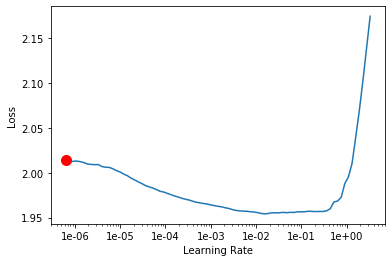

In [37]:
! rm models/bestmodel.pth
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [38]:
learner.fit_one_cycle(100,1.5e-3)

epoch,train_loss,valid_loss,👉🏻LMAE👈🏻,lmae0,lmae1,lmae2,lmae3,lmae4,lmae5,lmae6,lmae7,time
0,1.923160,1.900068,1.912084,4.546370,2.508763,3.840623,1.114149,1.128598,1.156542,1.077546,-0.075916,00:35
1,1.896336,1.850479,1.861903,4.557377,2.257590,3.837995,1.112092,1.016414,1.170805,1.026037,-0.083090,00:35
2,1.859745,1.796040,1.807070,4.558851,2.019801,3.836298,1.117859,0.945417,1.104309,0.974670,-0.100642,00:35
3,1.827177,1.750030,1.759744,4.556438,1.687487,3.835960,1.098810,0.926714,1.098469,0.966579,-0.092510,00:35
4,1.798473,1.710036,1.718670,4.552663,1.439460,3.832593,1.071974,0.915737,1.079052,0.955354,-0.097473,00:35
5,1.771950,1.678105,1.686272,4.548733,1.240661,3.830760,1.050669,0.904645,1.081646,0.943697,-0.110636,00:35
6,1.741322,1.651284,1.659049,4.545418,1.076431,3.830232,1.024180,0.885470,1.084973,0.941262,-0.115577,00:35
7,1.718283,1.636681,1.643380,4.539898,0.978736,3.827724,0.993823,0.887674,1.086348,0.920729,-0.087894,00:36
8,1.690624,1.613813,1.619510,4.537863,0.866910,3.821663,0.964368,0.872888,1.078340,0.927007,-0.112956,00:36
9,1.658581,1.583372,1.588312,4.534563,0.756868,3.813275,0.928321,0.854972,1.031071,0.916354,-0.128929,00:36


Better model found at epoch 0 with 👉🏻LMAE👈🏻 value: 1.9120843410491943.
Better model found at epoch 1 with 👉🏻LMAE👈🏻 value: 1.8619025945663452.
Better model found at epoch 2 with 👉🏻LMAE👈🏻 value: 1.807070255279541.
Better model found at epoch 3 with 👉🏻LMAE👈🏻 value: 1.759743571281433.
Better model found at epoch 4 with 👉🏻LMAE👈🏻 value: 1.7186700105667114.
Better model found at epoch 5 with 👉🏻LMAE👈🏻 value: 1.6862719058990479.
Better model found at epoch 6 with 👉🏻LMAE👈🏻 value: 1.6590485572814941.
Better model found at epoch 7 with 👉🏻LMAE👈🏻 value: 1.643379807472229.
Better model found at epoch 8 with 👉🏻LMAE👈🏻 value: 1.6195101737976074.
Better model found at epoch 9 with 👉🏻LMAE👈🏻 value: 1.5883119106292725.
Better model found at epoch 10 with 👉🏻LMAE👈🏻 value: 1.5807496309280396.
Better model found at epoch 11 with 👉🏻LMAE👈🏻 value: 1.54558527469635.
Better model found at epoch 12 with 👉🏻LMAE👈🏻 value: 1.525373935699463.
Better model found at epoch 13 with 👉🏻LMAE👈🏻 value: 1.4936565160751343.
Better m

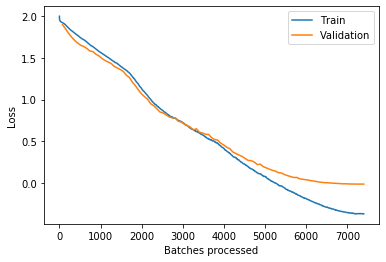

In [39]:
learner.recorder.plot_losses()

/home/antor/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 128073 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/antor/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 127995 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/antor/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 128072 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/antor/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 128073 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/antor/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 127995 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/antor/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.p

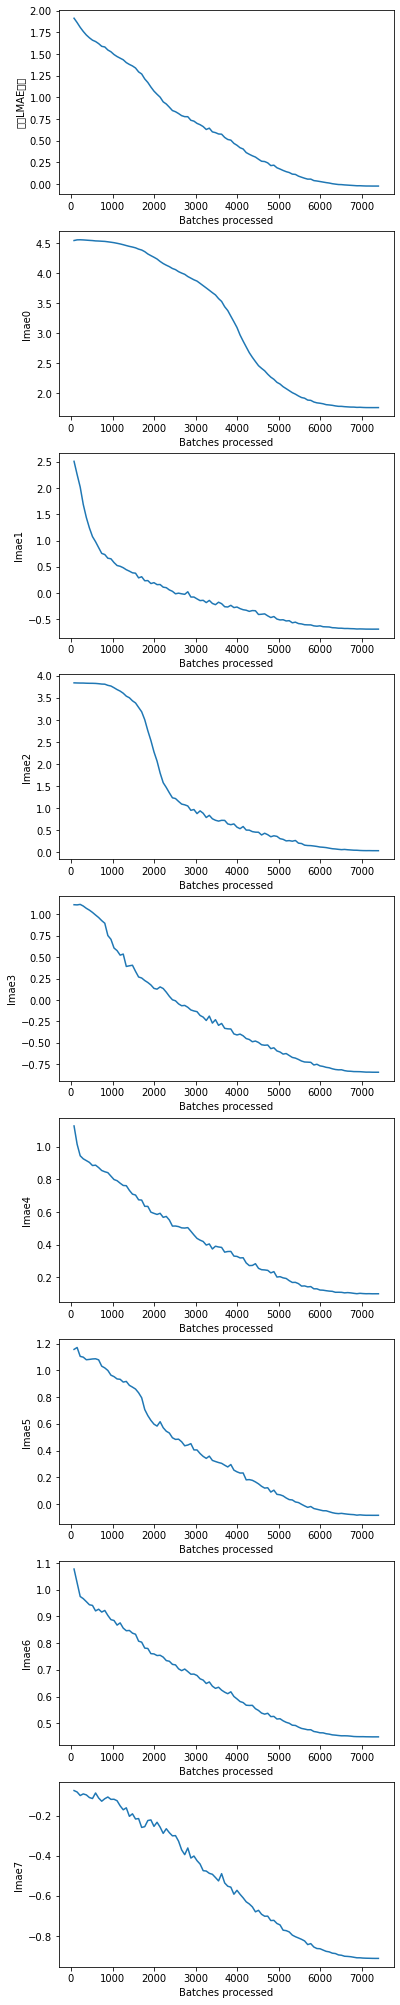

In [40]:
learner.recorder.plot_metrics()

## Optional Fine tune regular fit 

In [ ]:
learner.callbacks.append(
    ReduceLROnPlateauCallback(learner, monitor='train_loss', mode='min', factor=0.2, patience=3))

In [ ]:
learner.fit(100, 5e-5)# , moms=(0.75,0.70))

In [ ]:
learner.fit_one_cycle(300, 5e-4)#, moms=(0.75,0.70))

In [ ]:
learner.recorder.plot_lr(show_moms=True)

In [ ]:
learner.recorder.plot_losses()

In [ ]:
learner.recorder.plot_metrics()

In [ ]:
learner.fit(10,1e-4)

# Validate

In [ ]:
learner.to_fp32()
val = learner.validate()[1]
print(val)

In [ ]:
try:
    sub_fname = f'loss{learner.recorder.losses[-1]:.04f}val{val:.04f}'
except:
    sub_fname = f'val{val:.04f}'
learner.save(sub_fname)
print(sub_fname)

# Inference

Make sure `tranforms` are activated to test set otherwise TTA > 1 will be as TTA =1

In [ ]:
try:
    xt_coulombmat = load_fn(f'xt_coulombmat32{ext}.npy')
except:
    xt_coulombmat = np.load(f'xt_coulombmat{ext}.npy', allow_pickle=True)
    xt_coulombmat = np.array(xt_coulombmat.tolist()).astype(np.float32)
    np.save(f'xt_coulombmat32{ext}.npy', xt_coulombmat)

In [ ]:
test_fname = Path('test.npz')
try:
    npzfile  = np.load(fname_ext(test_fname, ext))
    xt_xyz   = npzfile['x_xyz']
    xt_type  = npzfile['x_type']
    xt_ext   = npzfile['x_ext']
    xt_atom  = npzfile['x_atom']
    mt = npzfile['m']
    xt_ids = npzfile['x_ids']
except:
    xt_xyz,xt_type,xt_ext,xt_atom,mt,xt_ids = \
        preprocess(test_fname.with_suffix('.csv'), type_index=types,ext=ext)
    np.savez(fname_ext('_'+test_fname, ext), 
             x_xyz  = xt_xyz,
             x_type = xt_type,
             x_ext  = xt_ext,
             x_atom = xt_atom,
             m=mt,
             x_ids=xt_ids)

In [ ]:
xt_qm9_mulliken = load_fn(f'xt_qm9_mulliken{ext}.npy')

In [ ]:
[v.shape for v in [xt_xyz,xt_type,xt_ext,xt_atom, xt_qm9_mulliken,xt_ids, mt]]

In [ ]:
learner.data.add_test(ItemList(items=(MoleculeItem(i,*v) for i,v in 
                              enumerate(zip(xt_xyz,xt_type,xt_ext,xt_atom,xt_qm9_mulliken,xt_coulombmat)))))

In [ ]:
TTA_N = 1
learner.data.test_ds.tfms = tta_tfms if TTA_N > 1 else tfms

In [ ]:
#learner.model = learner.model.module
#data.batch_size = 4096*2

In [ ]:
#learner.model = nn.DataParallel(learner.model)
old_bs = data.batch_size
data.batch_size *= 2

sub = defaultdict(int)
xt_ids_not_extended = (xt_ids!=0) & (xt_ids<=7163688) # TODO
ids = xt_ids[xt_ids_not_extended]

mb = master_bar(range(TTA_N))
for tta in mb:
    test_preds = np.zeros((0, 29), dtype=np.float32)

    for batch_idx, batch in progress_bar(
        enumerate(learner.dl(DatasetType.Test)), total=len(learner.dl(DatasetType.Test)), parent=mb):
        _, _, preds_,_,_,_ = learner.pred_batch(ds_type=DatasetType.Test, batch=batch)
        preds_ = preds_.sum(dim=1)
        test_preds = np.concatenate([test_preds, preds_.data.cpu().numpy()], axis = 0)

    preds = test_preds[xt_ids_not_extended]
    for k in range(len(ids)):
        sub[int(ids[k])] += preds[k]
    
for k in range(len(ids)):
    sub[int(ids[k])] = sub[int(ids[k])]/TTA_N

learner.model = learner.model.module
data.batch_size = old_bs

sub_df = pd.DataFrame(sub.items(), columns=['id', 'scalar_coupling_constant'])
sub_df.head()

# Submit to Kaggle

In [ ]:
csv_fname = f'{sub_fname}_tta{TTA_N}.csv'
sub_df.to_csv(csv_fname, index=False)

In [ ]:
comp = 'champs-scalar-coupling'

In [ ]:
!kaggle competitions submit -c {comp} -f {csv_fname} -m 'QM9 tta {TTA_N} {ext}'

In [ ]:
import time
time.sleep(60)
!kaggle competitions submissions -c {comp} -v > submissions-{comp}.csv

In [ ]:
submissions = pd.read_csv(f'submissions-{comp}.csv')
submissions.iloc[0].publicScore